In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
import p5lib
import pickle
import os.path

%matplotlib inline

### Load and preprocess data

The method ```preprocess_data``` chooses only the selected potential features and combine some columns that are mutually exclusive (such as 4 year college and < 4 year college). It also removes data that does not have Completion or Retention data because those are the target features. 

The result from preprocessing is stored in a pickle file so we can reload it much faster. 

In [49]:
pickle_file = 'reduced_data.pickle'
if os.path.isfile(pickle_file):
    data = pickle.load(open(pickle_file, "rb"))
else:
    data = pd.read_csv('MERGED2013_PP.csv')
    # print data.shape
    data = p5lib.preprocess_data(data)
    pickle.dump(data, open(pickle_file, "wb"))

print data.shape

(6007, 45)


### Split data into features and targets (X and y) 

We also get rid of data that are outliers (data with retention rate 0)

In [50]:
X = data[['CONTROL', 'DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'PAR_ED_PCT_1STGEN', 
          'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 'UGDS', 
          'WDRAW_DEBT_MDN', 'L4_COLLEGE', 'NPT4', 'NUM4', 
          'PFTFTUG1_EF', 'PFTFAC',
          'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 'AVGFACSAL', 'COSTT4_A',
          'CCSIZSET', 'CCUGPROF', 'CCBASIC', # carnegie classification data
          'C150', 'RET_FT']]

# remove noise, this bumps up the r2 score pretty nicely
# X = X[~((X.RET_FT == 0) & (X.C150 > 0.5))]
# X = X[~((X.C150 == 0) & (X.RET_FT > 0.5))]
# X = X[~((X.C150 == 1) & (X.RET_FT < 0.5))]
# X = X[~((X.RET_FT == 1) & (X.C150 < 0.5))]
X = X[~(X.RET_FT == 0)]

y = X[['C150', 'RET_FT']]
X = X.drop('C150', 1)
X = X.drop('RET_FT', 1)
print X.shape
print y.shape
print len(X.dropna())


(5960, 28)
(5960, 2)
1146


### Fill missing values with the means

In [51]:
fill_cols_with_mean = ['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'WDRAW_DEBT_MDN',
                       'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 
                       'UG25abv', 'NPT4', 'NUM4', 'PFTFTUG1_EF', 'PFTFAC', 'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 
                       'AVGFACSAL', 'COSTT4_A']

for col in fill_cols_with_mean:
    if col in X:
        X[col] = X[col].fillna(X[col].mean())

In [52]:
p5lib.print_num_data_for_each_features(X)

Number of available data for each feature (not counting the NaN values)
CONTROL             Control (public/private)                      5960
DEBT_MDN            Median debt                                   5960
DEP_INC_AVG         Avg income dependent stu                      5960
GRAD_DEBT_MDN       Median debt complete                          5960
IND_INC_AVG         Avg income independent stu                    5960
INEXPFTE            Expense per FTE student                       5960
PAR_ED_PCT_1STGEN   % 1st gen students                            5960
PAR_ED_PCT_HS       % parent education high school                5960
PAR_ED_PCT_MS       % parent education middle school              5960
PAR_ED_PCT_PS       % parent education post secondary             5960
PCTFLOAN            % Fed student loan                            5960
PCTPELL             % Pell Grant receiver                         5960
UG25abv             % undergrad > 25 yr                           5960
UGDS 

### Scale data

Process non-categorical data using standard scaler so they all have 0 means. 

In [53]:
from sklearn import preprocessing

# take features of type cost/money, and percentage (between 0 and 1) and preprocess with standard scaler
# and then use these preprocessed features for PCA
tmpX = X[['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'UGDS', 'WDRAW_DEBT_MDN', 'NPT4', 
          'NUM4', 'SAT_AVG_ALL', 'ACTCMMID', 'AVGFACSAL', 'COSTT4_A',
          'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 
          'PFTFTUG1_EF', 'PFTFAC', 'ADM_RATE_ALL'
         ]]

scaler = preprocessing.StandardScaler()

scaledX = scaler.fit_transform(tmpX)
print scaledX.shape


(5960, 23)


### Use PCA for dimensional reduction

In [54]:
from sklearn.decomposition import PCA

pca = PCA(n_components=scaledX.shape[1])
pca.fit(scaledX)

print pca.explained_variance_ratio_

[  3.27172733e-01   1.23599811e-01   9.71482969e-02   6.85430501e-02
   5.78347093e-02   4.73881578e-02   4.19985272e-02   3.92640360e-02
   3.46822758e-02   2.76923933e-02   2.50142190e-02   2.22809791e-02
   2.20554011e-02   1.60944642e-02   1.16668152e-02   9.24339709e-03
   7.56805099e-03   7.34731055e-03   4.92884099e-03   4.55383044e-03
   2.99018233e-03   6.09843373e-04   3.22675391e-04]


In [55]:
pca = PCA(n_components=15)
pca.fit(scaledX)
reducedX = pca.transform(scaledX)

# reducedX is the chosen top PCA components
print reducedX.shape

(5960, 15)


### Add categorical features as one hot encoded

In [56]:
tmp1X = np.array(pd.get_dummies(X['CONTROL']))
tmp2X = X['L4_COLLEGE'].astype(int)
tmp2X = np.reshape(tmp2X, (len(tmp2X), 1)) 

tmp3X = np.array(pd.get_dummies(X['CCSIZSET']))
tmp4X = np.array(pd.get_dummies(X['CCUGPROF']))
tmp5X = np.array(pd.get_dummies(X['CCBASIC']))

print reducedX.shape
print tmp1X.shape, tmp2X.shape, tmp3X.shape, tmp4X.shape, tmp5X.shape

finalX = np.concatenate((reducedX, tmp1X, tmp2X, tmp3X, tmp4X, tmp5X), axis=1)

print finalX.shape

(5960, 15)
(5960, 3) (5960, 1) (5960, 17) (5960, 14) (5960, 33)
(5960, 83)


### Train / test split

Optionally store the train/test split in a pickle file if we want to keep the same train/test data. In order to do this, comment out the os.remove line. 

(4768, 83)
(1192, 83)
(4768, 2)
(1192, 2)
       y_test c150  y_train c150
count  1192.000000   4768.000000
mean      0.521680      0.528953
std       0.242417      0.235952
min       0.000000      0.000000
25%       0.322173      0.340064
50%       0.544389      0.554805
75%       0.719004      0.718252
max       1.000000      1.000000
        y_test ret  y_train ret
count  1192.000000  4768.000000
mean      0.695433     0.698791
std       0.175746     0.166523
min       0.019200     0.032300
25%       0.591575     0.590900
50%       0.705900     0.710300
75%       0.818575     0.818200
max       1.000000     1.000000


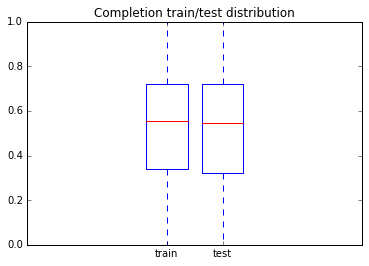

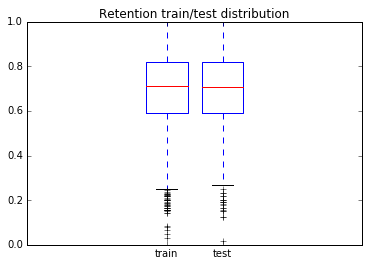

In [57]:
from sklearn import cross_validation as cv

pickle_file = 'm5-split_data.pickle'

os.remove(pickle_file) # clear cache (delete pickle). Comment this out to keep the same train/test data over multiple runs
if os.path.isfile(pickle_file):
    print "loading split_data from pickle"
    split_data = pickle.load(open(pickle_file, "rb"))
    X_train, X_test, y_train, y_test = split_data['X_train'], split_data['X_test'], split_data['y_train'], split_data['y_test']
else:
    y = np.array(y)
    X_train, X_test, y_train, y_test = cv.train_test_split(finalX, y, train_size=0.8)
    split_data = {
        'X_train': X_train,
        'X_test':  X_test,
        'y_train': y_train,
        'y_test':  y_test,        
    }
    pickle.dump(split_data, open(pickle_file, "wb"))

print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

# Check if the train / test has similar distribution
print pd.DataFrame(data={'y_train c150': pd.Series(y_train[:,0]).describe(),
                         'y_test c150': pd.Series(y_test[:,0]).describe(),
                        })
print pd.DataFrame(data={'y_train ret': pd.Series(y_train[:,1]).describe(),
                         'y_test ret': pd.Series(y_test[:,1]).describe(),
                        })
plt.title("Completion train/test distribution")
plt.boxplot([y_train[:,0], y_test[:,0]], labels=['train', 'test'], positions=[0.2, 0.4])
plt.show()
plt.title("Retention train/test distribution")
plt.boxplot([y_train[:,1], y_test[:,1]], labels=['train', 'test'], positions=[0.2, 0.4])
plt.show()


In [104]:
from sklearn import metrics
from sklearn import metrics
from sklearn import cross_validation as cv
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

def print_r2score(reg, X, y, test=False):
    t = 'test ' if test else 'train'
    r2score = metrics.r2_score(y, reg.predict(np.array(X)))
    print "R2 score on {} data: {}".format(t, r2score)
    return r2score

def print_mse(reg, X, y, test=False):
    t = 'test ' if test else 'train'
    mse = metrics.mean_squared_error(y, reg.predict(np.array(X)))
    print "MSE on {} data: {}".format(t, mse)
    return mse

def print_mae(reg, X, y, test=False):
    t = 'test ' if test else 'train'
    mae = metrics.mean_absolute_error(y, reg.predict(np.array(X)))
    print "MAE on {} data: {}".format(t, mae)
    return mae

r2_scorer = metrics.make_scorer(metrics.r2_score, greater_is_better=True)
mse_scorer = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)
mae_scorer = metrics.make_scorer(metrics.mean_absolute_error, greater_is_better=False)
default_scorer = mae_scorer

def split_y(y_train, y_test):
    return y_train[:,0], y_test[:,0], y_train[:,1], y_test[:,1]

def print_r2_summary(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test):
    print "--- R2 Completion ---"
    if hasattr(reg1, 'best_params_'):
        print "best params: {}".format(reg1.best_params_)
    r2_train_reg1 = print_r2score(reg1, X_train, y1_train)
    r2_test_reg1  = print_r2score(reg1, X_test, y1_test, test=True)

    print "--- R2 Retention ---"
    if hasattr(reg2, 'best_params_'):
        print "best params: {}".format(reg2.best_params_)
    r2_train_reg2 = print_r2score(reg2, X_train, y2_train)
    r2_test_reg2  = print_r2score(reg2, X_test, y2_test, test=True)

    return {'reg1': {'train': r2_train_reg1, 'test': r2_test_reg1 },
            'reg2': {'train': r2_train_reg2, 'test': r2_test_reg2 }}

def print_mse_summary(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test):
    print "--- MSE Completion ---"
    mse_train_reg1 = print_mse(reg1, X_train, y1_train)
    mse_test_reg1 = print_mse(reg1, X_test, y1_test, test=True)
    print "--- MSE Retention ---"
    mse_train_reg2 = print_mse(reg2, X_train, y2_train)
    mse_test_reg2 = print_mse(reg2, X_test, y2_test, test=True)
    return {'reg1': {'train': mse_train_reg1, 'test': mse_test_reg1 },
            'reg2': {'train': mse_train_reg2, 'test': mse_test_reg2 }}

def print_mae_summary(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test):
    print "--- MAE Completion ---"
    mae_train_reg1 = print_mae(reg1, X_train, y1_train)
    mae_test_reg1 = print_mae(reg1, X_test, y1_test, test=True)
    print "--- MAE Retention ---"
    mae_train_reg2 = print_mae(reg2, X_train, y2_train)
    mae_test_reg2 = print_mae(reg2, X_test, y2_test, test=True)
    return {'reg1': {'train': mae_train_reg1, 'test': mae_test_reg1 },
            'reg2': {'train': mae_train_reg2, 'test': mae_test_reg2 }}

def plot_err_metric(err, metric=None, model=None):
    plt.title('{} - {}'.format(metric, model))
    plt.bar(np.array(range(2)), [err['reg1']['train'], err['reg2']['train']], width=0.4, color='r')
    plt.bar(np.array(range(2))+0.4, [err['reg1']['test'], err['reg2']['test']], width=0.4, color='b')
    plt.ylabel(metric)
    plt.legend(['Train', 'Test'])
    plt.xticks(np.array(range(4))+ 0.4, ['Completion', 'Retention'])
    plt.show()
    
def build_DecisionTree_model(X_train, X_test, y_train, y_test, cv=3, scorer=None):
    if scorer == None:
        scorer = default_scorer
    y1_train, y1_test, y2_train, y2_test = split_y(y_train, y_test)

    parameters = {'max_depth': range(1,10)} # , 'min_samples_leaf': [4,5,6,7]}
    reg = DecisionTreeRegressor()
    best_reg1 = GridSearchCV(reg, parameters, scoring=scorer, cv=cv)
    best_reg1.fit(X_train, y1_train)

    reg = DecisionTreeRegressor()
    best_reg2 = GridSearchCV(reg, parameters, scoring=scorer, cv=cv)
    best_reg2.fit(X_train, y2_train)

    r2 = print_r2_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    mse = print_mse_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    mae = print_mae_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    plot_err_metric(r2, metric='R2 score', model='Decision Tree')
    plot_err_metric(mse, metric='MSE', model='Decision Tree')
    plot_err_metric(mae, metric='MAE', model='Decision Tree')
    
    return {'reg1': best_reg1, 'reg2': best_reg2, 'r2': r2, 'mse': mse, 'mae': mae}


## Build models

### Decision Tree

--- R2 Completion ---
best params: {'max_depth': 6}
R2 score on train data: 0.62620118919
R2 score on test  data: 0.518647728981
--- R2 Retention ---
best params: {'max_depth': 5}
R2 score on train data: 0.294741334082
R2 score on test  data: 0.199337544976
--- MSE Completion ---
MSE on train data: 0.0208061968673
MSE on test  data: 0.0282634144811
--- MSE Retention ---
MSE on train data: 0.0195526627552
MSE on test  data: 0.024709149578
--- MAE Completion ---
MAE on train data: 0.106958489475
MAE on test  data: 0.123911888429
--- MAE Retention ---
MAE on train data: 0.101960361777
MAE on test  data: 0.113436470421


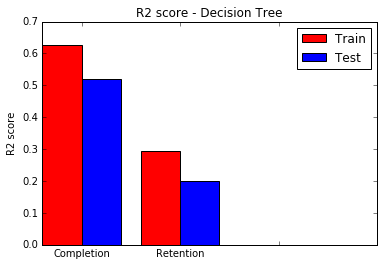

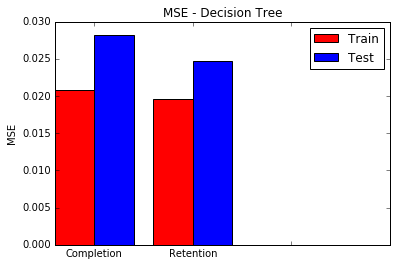

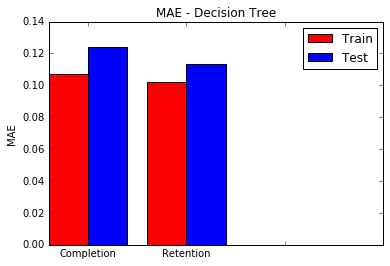

In [105]:
DT19_model = build_DecisionTree_model(X_train[:,:19], X_test[:,:19], y_train, y_test)

--- R2 Completion ---
best params: {'max_depth': 6}
R2 score on train data: 0.637894804338
R2 score on test  data: 0.518573903875
--- R2 Retention ---
best params: {'max_depth': 6}
R2 score on train data: 0.341270447347
R2 score on test  data: 0.214028687217
--- MSE Completion ---
MSE on train data: 0.0201553128842
MSE on test  data: 0.0282677492473
--- MSE Retention ---
MSE on train data: 0.0182626849017
MSE on test  data: 0.0242557679703
--- MAE Completion ---
MAE on train data: 0.105915430566
MAE on test  data: 0.125122361727
--- MAE Retention ---
MAE on train data: 0.0976769290016
MAE on test  data: 0.111611112145


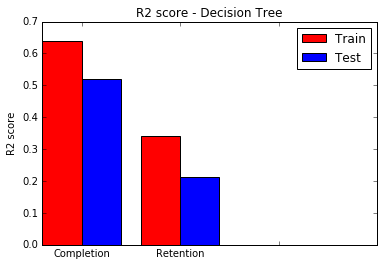

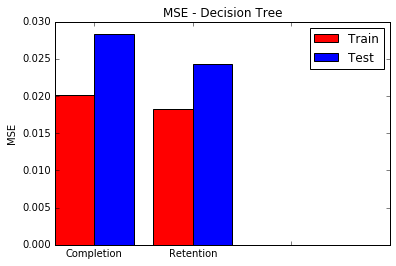

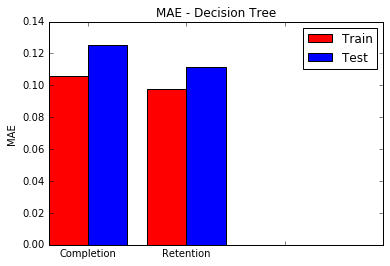

In [106]:
DT_model = build_DecisionTree_model(X_train, X_test, y_train, y_test)

### SVR

In [107]:
def build_SVR_model(X_train, X_test, y_train, y_test, cv=3, params=None, scorer=None):
    if scorer == None:
        scorer = default_scorer
    y1_train, y1_test, y2_train, y2_test = split_y(y_train, y_test)

    if params == None:
        params = {'C': np.logspace(-1, 1, 2), 'gamma': np.logspace(-1, 1, 2), 'epsilon': np.logspace(-1, 1, 2)}
    reg = SVR()
    best_reg1 = GridSearchCV(reg, params, scoring=scorer, cv=cv)
    best_reg1.fit(X_train, y1_train)

    reg = SVR()
    best_reg2 = GridSearchCV(reg, params, scoring=scorer, cv=cv)
    best_reg2.fit(X_train, y2_train)

    r2 = print_r2_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    mse = print_mse_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    mae = print_mae_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    plot_err_metric(r2, metric='R2 score', model='SVR')
    plot_err_metric(mse, metric='MSE', model='SVR')
    plot_err_metric(mae, metric='MAE', model='SVR')
    
    return {'reg1': best_reg1, 'reg2': best_reg2, 'r2': r2, 'mse': mse, 'mae': mae}


--- R2 Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.733314534808
R2 score on test  data: 0.645001997596
--- R2 Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.463104740025
R2 score on test  data: 0.299941838505
--- MSE Completion ---
MSE on train data: 0.0148441089965
MSE on test  data: 0.0208443094299
--- MSE Retention ---
MSE on train data: 0.0148849386196
MSE on test  data: 0.0216044123427
--- MAE Completion ---
MAE on train data: 0.0927192825714
MAE on test  data: 0.108668949397
--- MAE Retention ---
MAE on train data: 0.0881819607875
MAE on test  data: 0.104856675359


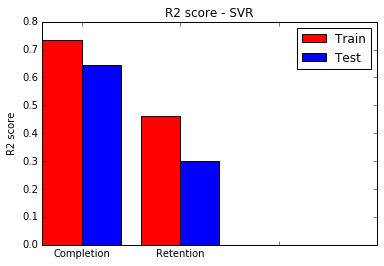

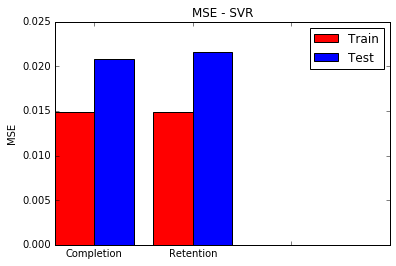

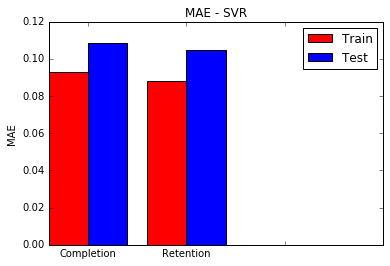

In [108]:
SVR19_model = build_SVR_model(X_train[:,:19], X_test[:,:19], y_train, y_test)

--- R2 Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.750379740881
R2 score on test  data: 0.651066338906
--- R2 Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.485767942416
R2 score on test  data: 0.291244134889
--- MSE Completion ---
MSE on train data: 0.0138942342862
MSE on test  data: 0.0204882313508
--- MSE Retention ---
MSE on train data: 0.0142566216989
MSE on test  data: 0.021872831148
--- MAE Completion ---
MAE on train data: 0.0902203934395
MAE on test  data: 0.107984680394
--- MAE Retention ---
MAE on train data: 0.0866739579887
MAE on test  data: 0.10553495987


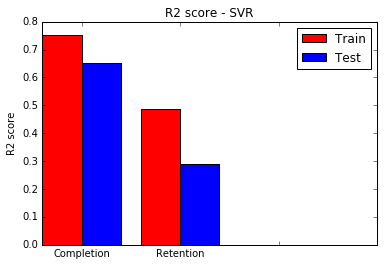

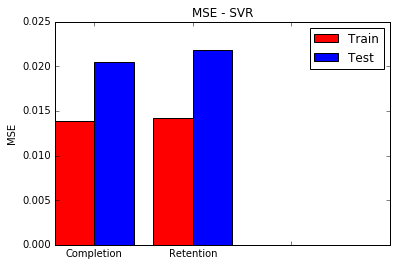

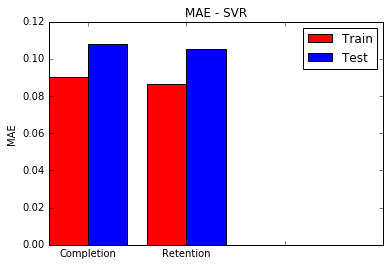

In [109]:
SVR_model = build_SVR_model(X_train, X_test, y_train, y_test)

### KNN

In [110]:
def build_KNN_model(X_train, X_test, y_train, y_test, cv=3, scorer=None):
    if scorer == None:
        scorer = default_scorer
    y1_train, y1_test, y2_train, y2_test = split_y(y_train, y_test)

    parameters = {'n_neighbors': range(5,20)}
    reg = KNeighborsRegressor()
    best_reg1 = GridSearchCV(reg, parameters, scoring=scorer, cv=cv)
    best_reg1.fit(X_train, y1_train)

    parameters = {'n_neighbors': range(5, 20)}
    reg = KNeighborsRegressor()
    best_reg2 = GridSearchCV(reg, parameters, scoring=scorer, cv=cv)
    best_reg2.fit(X_train, y2_train)

    r2 = print_r2_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    mse = print_mse_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    mae = print_mae_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    plot_err_metric(r2, metric='R2 score', model='KNN')
    plot_err_metric(mse, metric='MSE', model='KNN')
    plot_err_metric(mae, metric='MAE', model='KNN')
    
    return {'reg1': best_reg1, 'reg2': best_reg2, 'r2': r2, 'mse': mse, 'mae': mae}

--- R2 Completion ---
best params: {'n_neighbors': 8}
R2 score on train data: 0.74169484865
R2 score on test  data: 0.65137945933
--- R2 Retention ---
best params: {'n_neighbors': 13}
R2 score on train data: 0.434677622116
R2 score on test  data: 0.286292340393
--- MSE Completion ---
MSE on train data: 0.014377648284
MSE on test  data: 0.0204698459545
--- MSE Retention ---
MSE on train data: 0.0156730549185
MSE on test  data: 0.0220256478938
--- MAE Completion ---
MAE on train data: 0.0862875119798
MAE on test  data: 0.104844938729
--- MAE Retention ---
MAE on train data: 0.088159021683
MAE on test  data: 0.103218236964


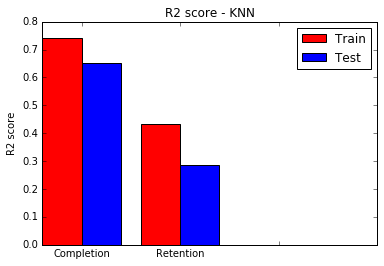

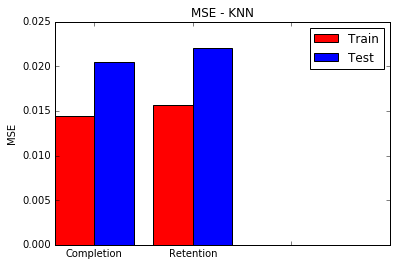

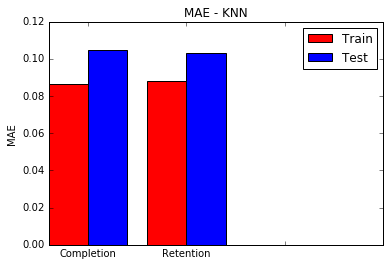

In [111]:
KNN19_model = build_KNN_model(X_train[:,:19], X_test[:,:19], y_train, y_test)

--- R2 Completion ---
best params: {'n_neighbors': 9}
R2 score on train data: 0.737103557042
R2 score on test  data: 0.658489764137
--- R2 Retention ---
best params: {'n_neighbors': 14}
R2 score on train data: 0.429485776266
R2 score on test  data: 0.279073737309
--- MSE Completion ---
MSE on train data: 0.0146332063926
MSE on test  data: 0.0200523523558
--- MSE Retention ---
MSE on train data: 0.0158169941793
MSE on test  data: 0.0222484203521
--- MAE Completion ---
MAE on train data: 0.0872254513767
MAE on test  data: 0.102773100321
--- MAE Retention ---
MAE on train data: 0.0881756157119
MAE on test  data: 0.103910282838


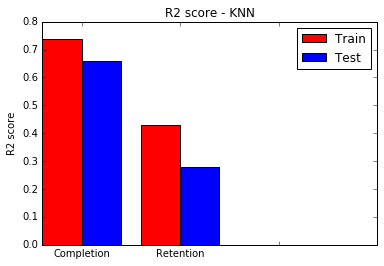

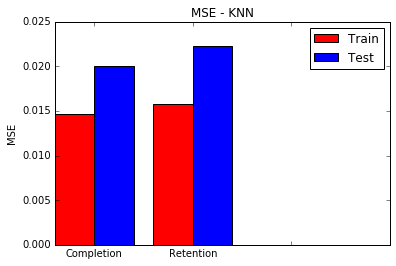

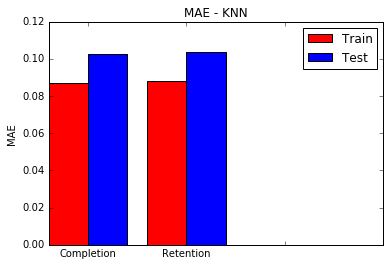

In [112]:
KNN_model = build_KNN_model(X_train, X_test, y_train, y_test)

### Random Forest

In [113]:
def build_RandomForest_model(X_train, X_test, y_train, y_test, n_estimators=10, scorer=None):
    if scorer == None:
        scorer = default_scorer
    y1_train, y1_test, y2_train, y2_test = split_y(y_train, y_test)

    reg1 = RandomForestRegressor(n_estimators=n_estimators)
    reg1.fit(X_train, y1_train)

    reg2 = RandomForestRegressor(n_estimators=n_estimators)
    reg2.fit(X_train, y2_train)

    r2 = print_r2_summary(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    mse = print_mse_summary(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    mae = print_mae_summary(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    plot_err_metric(r2, metric='R2 score', model='Random Forest')
    plot_err_metric(mse, metric='MSE', model='Random Forest')
    plot_err_metric(mae, metric='MAE', model='Random Forest')
    
    return {'reg1': reg1, 'reg2': reg2, 'r2': r2, 'mse': mse, 'mae': mae}

--- R2 Completion ---
R2 score on train data: 0.949716902326
R2 score on test  data: 0.643645483017
--- R2 Retention ---
R2 score on train data: 0.905292596462
R2 score on test  data: 0.275181116723
--- MSE Completion ---
MSE on train data: 0.00279883188242
MSE on test  data: 0.0209239594827
--- MSE Retention ---
MSE on train data: 0.0026256776574
MSE on test  data: 0.0223685500568
--- MAE Completion ---
MAE on train data: 0.0381492107595
MAE on test  data: 0.106378875943
--- MAE Retention ---
MAE on train data: 0.0356771573384
MAE on test  data: 0.104826496782


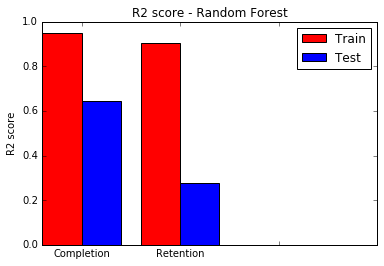

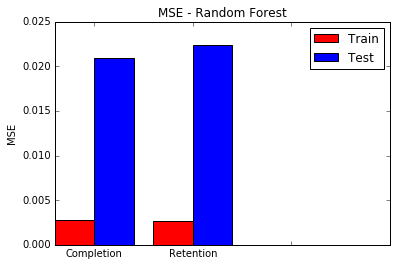

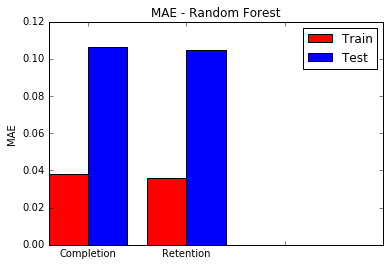

In [114]:
RF19_model = build_RandomForest_model(X_train[:,:19], X_test[:,:19], y_train, y_test, n_estimators=50)

--- R2 Completion ---
R2 score on train data: 0.952644354563
R2 score on test  data: 0.65964991095
--- R2 Retention ---
R2 score on train data: 0.905312917453
R2 score on test  data: 0.286800864514
--- MSE Completion ---
MSE on train data: 0.00263588554391
MSE on test  data: 0.0199842323692
--- MSE Retention ---
MSE on train data: 0.00262511427619
MSE on test  data: 0.0220099543909
--- MAE Completion ---
MAE on train data: 0.0368449764809
MAE on test  data: 0.103120615357
--- MAE Retention ---
MAE on train data: 0.0356155080296
MAE on test  data: 0.103923039461


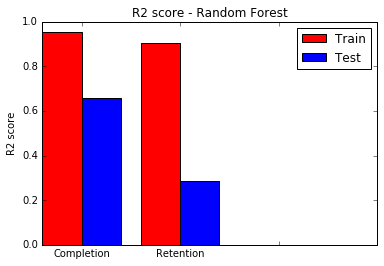

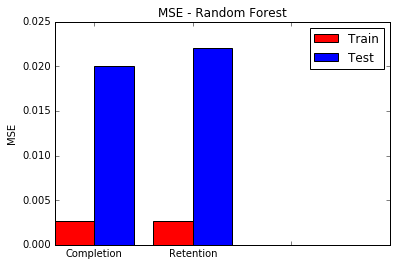

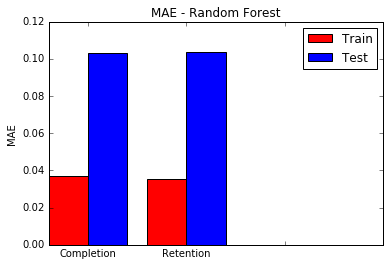

In [115]:
RF_model = build_RandomForest_model(X_train, X_test, y_train, y_test, n_estimators=50)

In [116]:
def plot_compare_metric(models, model_names=[], metric=None):
    train_scores1, test_scores1, train_scores2, test_scores2 = [], [], [], []
    for m in models:
        train_scores1.append(m[metric]['reg1']['train'])
        test_scores1.append(m[metric]['reg1']['test'])
        train_scores2.append(m[metric]['reg2']['train'])
        test_scores2.append(m[metric]['reg2']['test'])
    
    plt.title('Completion models - {}'.format(metric.upper()))
    plt.bar(np.array(range(len(models))), train_scores1, width=0.4, color='r')
    plt.bar(np.array(range(len(models)))+0.4, test_scores1, width=0.4, color='b')
    plt.ylabel(metric.upper())
    plt.legend(['Train', 'Test'])
    plt.xticks(np.array(range(len(models)+2))+ 0.4, model_names)
    plt.show()
    
    plt.title('Retention models - {}'.format(metric.upper()))
    plt.bar(np.array(range(len(models))), train_scores2, width=0.4, color='r')
    plt.bar(np.array(range(len(models)))+0.4, test_scores2, width=0.4, color='b')
    plt.ylabel(metric.upper())
    plt.legend(['Train', 'Test'])
    plt.xticks(np.array(range(len(models)+2))+ 0.4, model_names)
    plt.show()

### Comparing R2, MSE and MAE between models with 19 features

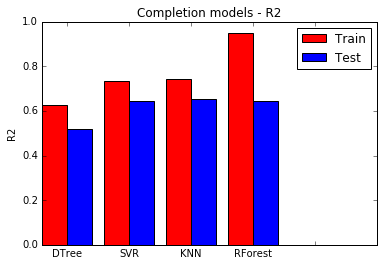

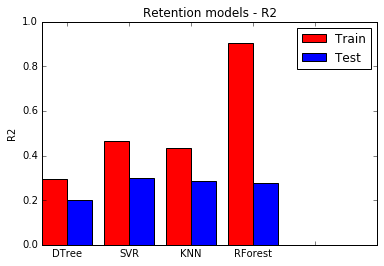

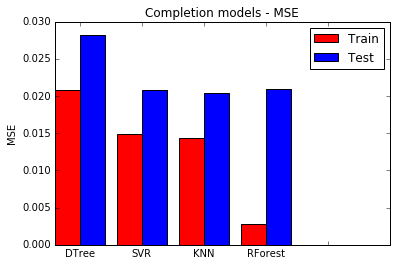

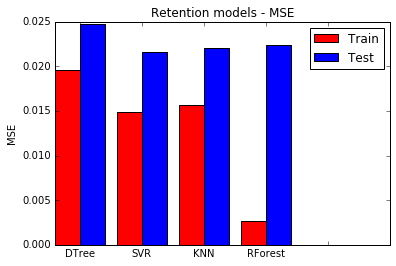

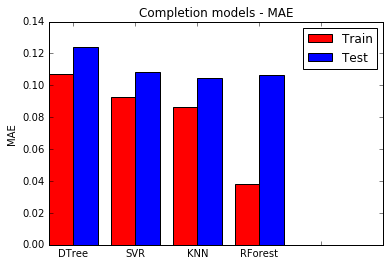

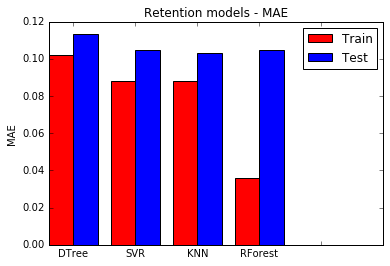

In [117]:
plot_compare_metric([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='r2')
plot_compare_metric([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mse')
plot_compare_metric([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mae')
    

### Comparing R2, MSE and MAE between models with 83 features

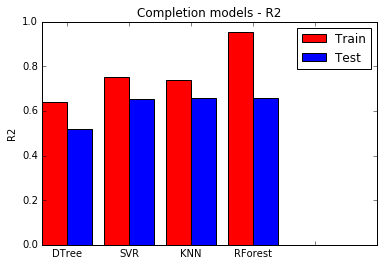

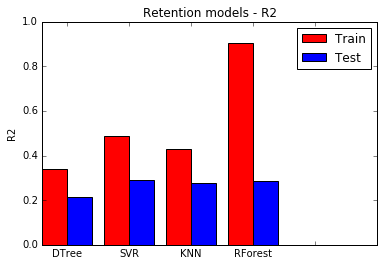

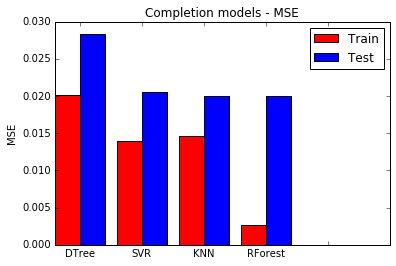

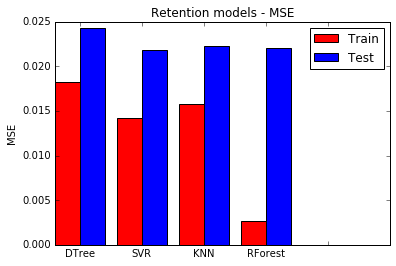

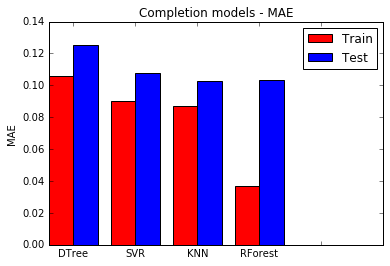

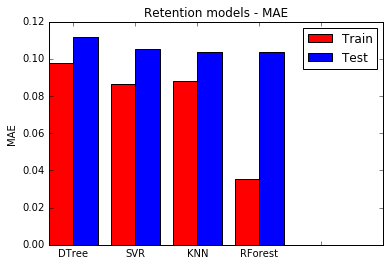

In [118]:
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='r2')
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mse')
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mae')

### Comparing R2, MSE, MAE on test data between models with 19 and 83 features

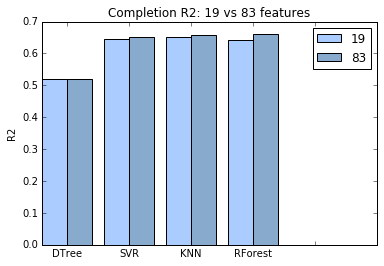

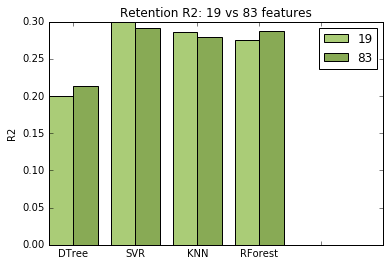

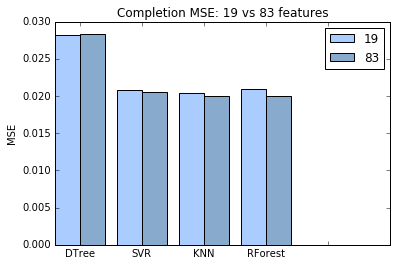

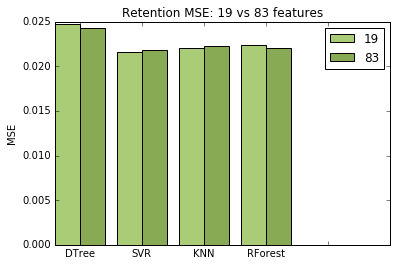

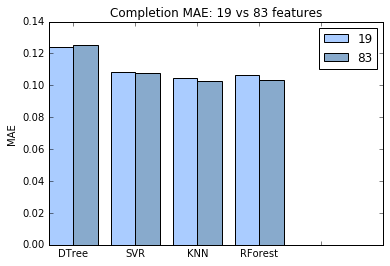

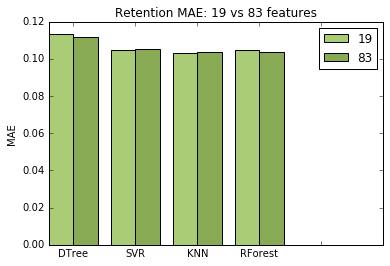

In [119]:
def plot_model_improvement(models1, models2, model_names=[], metric=None):
    completion_scores1, completion_scores2 = [], []
    retention_scores1, retention_scores2 = [], []
    for m in models1:
        completion_scores1.append(m[metric]['reg1']['test'])
        retention_scores1.append(m[metric]['reg2']['test'])
    for m in models2:
        completion_scores2.append(m[metric]['reg1']['test'])
        retention_scores2.append(m[metric]['reg2']['test'])
    
    plt.title('Completion {}: 19 vs 83 features'.format(metric.upper()))
    plt.bar(np.array(range(len(models1))), completion_scores1, width=0.4, color='#aaccff')
    plt.bar(np.array(range(len(models1)))+0.4, completion_scores2, width=0.4, color='#88aacc')
    plt.ylabel(metric.upper())
    plt.legend(['19', '83'])
    plt.xticks(np.array(range(len(models1)+2))+ 0.4, model_names)
    plt.show()
    
    plt.title('Retention {}: 19 vs 83 features'.format(metric.upper()))
    plt.bar(np.array(range(len(models1))), retention_scores1, width=0.4, color='#aacc77')
    plt.bar(np.array(range(len(models1)))+0.4, retention_scores2, width=0.4, color='#88aa55')
    plt.ylabel(metric.upper())
    plt.legend(['19', '83'])
    plt.xticks(np.array(range(len(models1)+2))+ 0.4, model_names)
    plt.show()

plot_model_improvement([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                       [DT_model, SVR_model, KNN_model, RF_model],
                       ['DTree', 'SVR', 'KNN', 'RForest'],
                       metric='r2')
plot_model_improvement([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                       [DT_model, SVR_model, KNN_model, RF_model],
                       ['DTree', 'SVR', 'KNN', 'RForest'],
                       metric='mse')
plot_model_improvement([DT19_model, SVR19_model, KNN19_model, RF19_model], 
                       [DT_model, SVR_model, KNN_model, RF_model],
                       ['DTree', 'SVR', 'KNN', 'RForest'],
                       metric='mae')

### Using Completion model to help predict Retention rate

Because the Completion model has a pretty good r2 score compared to the Retention model, we could use the Completion model to help predict the Retention. This might work because there is a clear positive linear correlation between completion and retention.

For this improvement, the implementation for the completion model is exactly the same. However, the retention model will have one more feature--the completion rate. The retention model is trained using the same X_train + y1_train (the completion rate data). When doing prediction on the test set, the retention model takes the X_test + the predicted completion rate from the completion model.

In [120]:
from sklearn.ensemble import RandomForestRegressor

# convert 1 dimensional N array into 2 dimensional Nx1
def reshape_y(y):
    return y.reshape((len(y), 1))

def print_r2_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted):
    print "--- R2 Completion ---"
    if hasattr(reg1, 'best_params_'):
        print "best params: {}".format(reg1.best_params_)
    r2_train_reg1 = print_r2score(reg1, X_train, y1_train)
    r2_test_reg1  = print_r2score(reg1, X_test, y1_test, test=True)
    print "--- R2 Retention ---"
    if hasattr(reg2, 'best_params_'):
        print "best params: {}".format(reg2.best_params_)
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    X_test1 = np.concatenate((X_test, reshape_y(y1_test_predicted)), axis=1)
    r2_train_reg2 = print_r2score(reg2, X_train1, y2_train)
    r2_test_reg2  = print_r2score(reg2, X_test1, y2_test, test=True)

    return {'reg1': {'train': r2_train_reg1, 'test': r2_test_reg1 },
            'reg2': {'train': r2_train_reg2, 'test': r2_test_reg2 }}

def print_mse_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted):
    print "--- MSE Completion ---"
    mse_train_reg1 = print_mse(reg1, X_train, y1_train)
    mse_test_reg1 = print_mse(reg1, X_test, y1_test, test=True)
    print "--- MSE Retention ---"
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    X_test1 = np.concatenate((X_test, reshape_y(y1_test_predicted)), axis=1)
    mse_train_reg2 = print_mse(reg2, X_train1, y2_train)
    mse_test_reg2 = print_mse(reg2, X_test1, y2_test, test=True)
    
    return {'reg1': {'train': mse_train_reg1, 'test': mse_test_reg1 },
            'reg2': {'train': mse_train_reg2, 'test': mse_test_reg2 }}

def print_mae_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted):
    print "--- MAE Completion ---"
    mae_train_reg1 = print_mae(reg1, X_train, y1_train)
    mae_test_reg1 = print_mae(reg1, X_test, y1_test, test=True)
    print "--- MAE Retention ---"
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    X_test1 = np.concatenate((X_test, reshape_y(y1_test_predicted)), axis=1)
    mae_train_reg2 = print_mae(reg2, X_train1, y2_train)
    mae_test_reg2 = print_mae(reg2, X_test1, y2_test, test=True)
    
    return {'reg1': {'train': mae_train_reg1, 'test': mae_test_reg1 },
            'reg2': {'train': mae_train_reg2, 'test': mae_test_reg2 }}

# build the model for Retention (y2) using the Completion data (y1)
# So the Retention model uses the prediction result from the Completion model
# Because we feed the prediction from completion model to the retention model, let's call this nested model
def build_RandomForest_model_nested(X_train, X_test, y_train, y_test, n_estimators=50):
    y1_train, y1_test, y2_train, y2_test = split_y(y_train, y_test)

    reg1 = RandomForestRegressor(n_estimators=n_estimators)
    reg1.fit(X_train, y1_train)

    reg2 = RandomForestRegressor(n_estimators=n_estimators)
    
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    reg2.fit(X_train1, y2_train)

    print "--- Completion ---"
    print_r2score(reg1, X_train, y1_train)
    r2score_reg1 = print_r2score(reg1, X_test, y1_test, test=True)

    print "--- Retention ---"
    print_r2score(reg2, X_train1, y2_train)
    y1_test_predicted = reg1.predict(X_test)
    X_test1 = np.concatenate((X_test, reshape_y(y1_test_predicted)), axis=1)
    r2score_reg2 = print_r2score(reg2, X_test1, y2_test, test=True)
    
    r2 = print_r2_summary_nested(tmpreg1, tmpreg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
    mse = print_mse_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
    mae = print_mae_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
#     plot_err_metric(r2, metric='R2 score', model='Random Forest nested')
#     plot_err_metric(mse, metric='MSE', model='Random Forest nested')
#     plot_err_metric(mae, metric='MAE', model='Random Forest nested')
    
    return {'reg1': reg1, 'reg2': reg2, 'r2': r2, 'mse': mse, 'mae': mae}

RF_nested = build_RandomForest_model_nested(X_train, X_test, y_train, y_test)


--- Completion ---
R2 score on train data: 0.953224867745
R2 score on test  data: 0.653894248456
--- Retention ---
R2 score on train data: 0.911782255375
R2 score on test  data: 0.287708611585
--- R2 Completion ---
R2 score on train data: 0.89069144729
R2 score on test  data: 0.888676182056
--- R2 Retention ---
R2 score on train data: 0.804045645159
R2 score on test  data: 0.486058389757
--- MSE Completion ---
MSE on train data: 0.0026035733182
MSE on test  data: 0.0203221858483
--- MSE Retention ---
MSE on train data: 0.00244575769577
MSE on test  data: 0.0219819405156
--- MAE Completion ---
MAE on train data: 0.0367746767605
MAE on test  data: 0.104000122154
--- MAE Retention ---
MAE on train data: 0.0332885577979
MAE on test  data: 0.103875930716


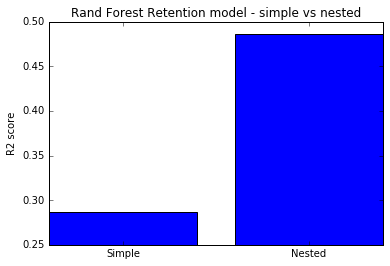

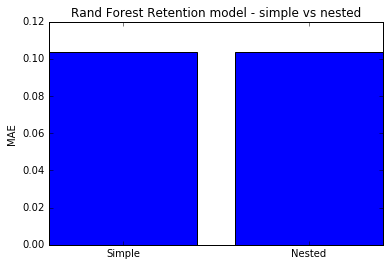

In [135]:
# Comparison of r2 score between simple vs nested model (using RandomForest) 
ret_r2  = [RF_model['r2']['reg2']['test'], RF_nested['r2']['reg2']['test']]
ret_mae  = [RF_model['mae']['reg2']['test'], RF_nested['mae']['reg2']['test']]

plt.title('Rand Forest Retention model - simple vs nested')
ax = plt.subplot(111)
ax.set_ylim([0.25, 0.50])
ax.bar(np.array(range(2)), ret_r2, width=0.8, color='b')
plt.ylabel('R2 score')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()

plt.title('Rand Forest Retention model - simple vs nested')
ax = plt.subplot(111)
# ax.set_ylim([0.25, 0.50])
ax.bar(np.array(range(2)), ret_mae, width=0.8, color='b')
plt.ylabel('MAE')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()


In [122]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

# build the model for Retention (y2) using the Completion data (y1)
# So the Retention model uses the prediction result from the Completion model
# Because we feed the prediction from completion model to the retention model, let's call this nested model
def build_SVR_model_nested(X_train, X_test, y_train, y_test, cv=3, params=None):
    y1_train, y1_test, y2_train, y2_test = p5lib.split_y(y_train, y_test)

    if params == None:
        params = {'C': np.logspace(-1, 1, 2), 'gamma': np.logspace(-1, 1, 2), 'epsilon': np.logspace(-1, 1, 2)}
    reg = SVR()
    scorer = default_scorer
    reg1 = GridSearchCV(reg, params, scoring=scorer, cv=cv)
    reg1.fit(X_train, y1_train)

    reg = SVR()
    reg2 = GridSearchCV(reg, params, scoring=scorer, cv=cv)
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    reg2.fit(X_train1, y2_train)

    print "--- Completion ---"
    p5lib.print_r2score(reg1, X_train, y1_train)
    r2score_reg1 = p5lib.print_r2score(reg1, X_test, y1_test, test=True)

    print "--- Retention ---"
    p5lib.print_r2score(reg2, X_train1, y2_train)
    y1_test_predicted = reg1.predict(X_test)
    X_test1 = np.concatenate((X_test, reshape_y(y1_test_predicted)), axis=1)
    r2score_reg2 = p5lib.print_r2score(reg2, X_test1, y2_test, test=True)

    r2 = print_r2_summary_nested(tmpreg1, tmpreg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
    mse = print_mse_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
    mae = print_mae_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)

    return {'reg1': reg1, 'reg2': reg2, 'r2': r2, 'mse': mse, 'mae': mae}

SVR_nested = build_SVR_model_nested(X_train, X_test, y_train, y_test)


--- Completion ---
R2 score on train data: 0.750379740881
R2 score on test  data: 0.651066338906
--- Retention ---
R2 score on train data: 0.507903761144
R2 score on test  data: 0.290422023611
--- R2 Completion ---
R2 score on train data: 0.89069144729
R2 score on test  data: 0.888676182056
--- R2 Retention ---
R2 score on train data: 0.804045645159
R2 score on test  data: 0.493407072998
--- MSE Completion ---
MSE on train data: 0.0138942342862
MSE on test  data: 0.0204882313508
--- MSE Retention ---
MSE on train data: 0.0136429260163
MSE on test  data: 0.0218982022272
--- MAE Completion ---
MAE on train data: 0.0902203934395
MAE on test  data: 0.107984680394
--- MAE Retention ---
MAE on train data: 0.08381387363
MAE on test  data: 0.105914384257


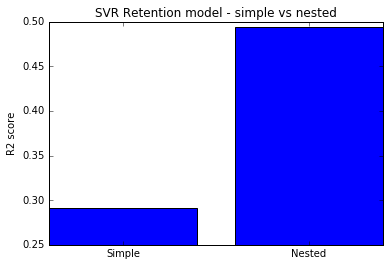

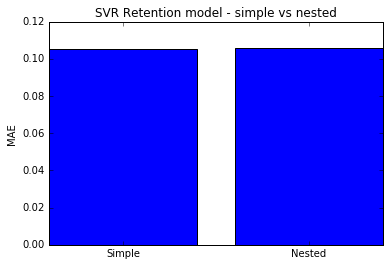

In [134]:
# Comparison of r2 score between simple vs nested model (using SVR model) 
ret_r2  = [SVR_model['r2']['reg2']['test'], SVR_nested['r2']['reg2']['test']]
ret_mae  = [SVR_model['mae']['reg2']['test'], SVR_nested['mae']['reg2']['test']]

plt.title('SVR Retention model - simple vs nested')
ax = plt.subplot(111)
ax.set_ylim([0.25, 0.50])
ax.bar(np.array(range(2)), ret_r2, width=0.8, color='b')

plt.ylabel('R2 score')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()

plt.title('SVR Retention model - simple vs nested')
ax = plt.subplot(111)
# ax.set_ylim([0.10, 0.11])
ax.bar(np.array(range(2)), ret_mae, width=0.8, color='b')

plt.ylabel('MAE')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()


### Sensitivity analysis

Sensitivity analysis is done by choosing 100 random data from the training set and changing the input by a little bit to see how different the prediction result for each model is. The difference in prediction result are collected and visualized using whisker plot to see the stability of the model.

Statistical analysis of difference in result when the input have small changes


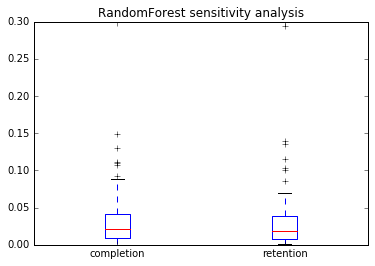

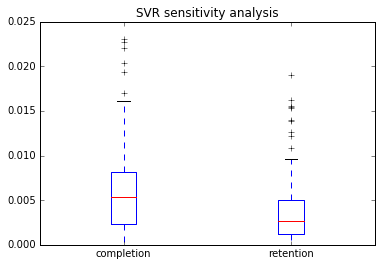

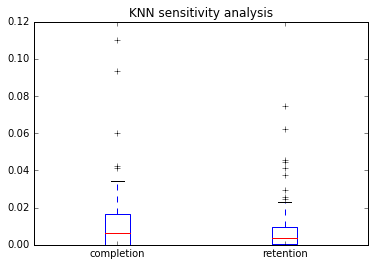

In [124]:

def final_nested_model_predict(reg1, reg2, X):
    y1_predicted = reg1.predict(X)
    X1 = np.concatenate((X, reshape_y(y1_predicted)), axis=1)
    y2_predicted = reg2.predict(X1)
    return y1_predicted, y2_predicted

def final_model_predict(reg1, reg2, X):
    y1_predicted = reg1.predict(X)
    y2_predicted = reg2.predict(X)
    return y1_predicted, y2_predicted

def sensitivity_analysis(reg1, reg2, data, title=''):
    delta_y1, delta_y2 = [], []
    
    for i, row in enumerate(data):
        X_nearby = row.copy()
        for j, a in enumerate(X_nearby):
            span = X_train[:,j].max() - X_train[:,j].min()
            if j < 15:
                X_nearby[j] += span/200

        y1p, y2p = final_model_predict(reg1, reg2, [row]) # predicted value
        y1pn, y2pn = final_model_predict(reg1, reg2, [X_nearby]) # predicted nearby value
        delta_y1.append(abs(y1pn[0] - y1p[0]))
        delta_y2.append(abs(y2pn[0] - y2p[0]))
    
    plt.title("{} sensitivity analysis".format(title))
    plt.boxplot([delta_y1, delta_y2], labels=['completion', 'retention'])
    plt.show()

print "Statistical analysis of difference in result when the input have small changes"
# Just test on a subset of the data (because it's really slow)
X_train_subset = X_train[np.random.choice(len(X_train), 100, replace=False)]

sensitivity_analysis(RF_model['reg1'], RF_model['reg2'], data=X_train_subset, title='RandomForest')
sensitivity_analysis(SVR_model['reg1'], SVR_model['reg2'], data=X_train_subset, title='SVR')
sensitivity_analysis(KNN_model['reg1'], KNN_model['reg2'], data=X_train_subset, title='KNN')


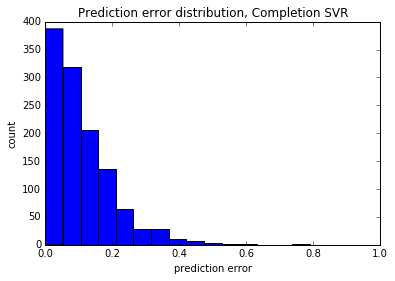

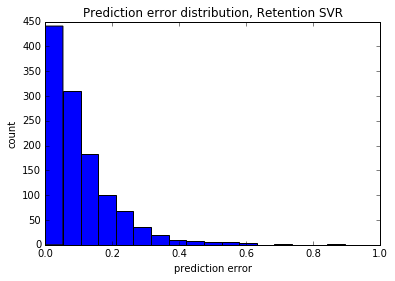

In [174]:

def hist_plot_delta(model, X, y, model_name=None, nested=False):
    bucket = np.linspace(0, 1, 20)
    y1, y2 = y[:,0], y[:,1]
    
    y1_predicted = model['reg1'].predict(X)
    if nested:
        X_tmp = np.concatenate((X, reshape_y(y1_predicted)), axis=1)
        y2_predicted = model['reg2'].predict(X_tmp)
    else:
        y2_predicted = model['reg2'].predict(X)
    delta1 = abs(y1 - y1_predicted)
    delta2 = abs(y2 - y2_predicted)
    
    plt.title('Prediction error distribution, Completion {}'.format(model_name))
    plt.xlabel('prediction error')
    plt.ylabel('count')
    plt.hist(delta1, bucket)
    plt.show()
    
    plt.title('Prediction error distribution, Retention {}'.format(model_name))
    plt.xlabel('prediction error')
    plt.ylabel('count')
    plt.hist(delta2, bucket)
    plt.show()
    
hist_plot_delta(SVR_model, X_test, y_test, model_name='SVR')


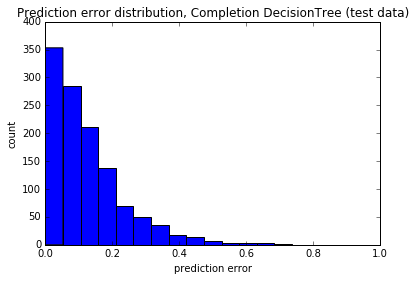

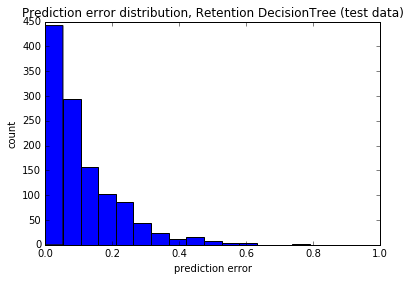

In [175]:
hist_plot_delta(DT_model, X_test, y_test, model_name='DecisionTree (test data)')
# hist_plot_delta(DT_model, X_train, y_train, model_name='DecisionTree (train data)')

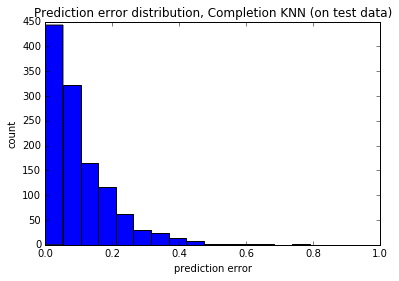

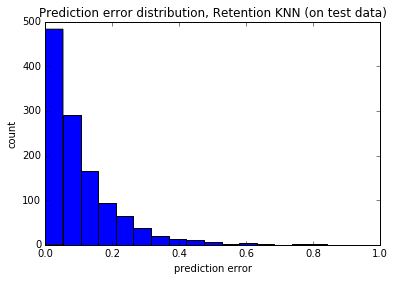

In [176]:
hist_plot_delta(KNN_model, X_test, y_test, model_name='KNN (on test data)')
# hist_plot_delta(KNN_model, X_train, y_train, model_name='KNN (on train data)')

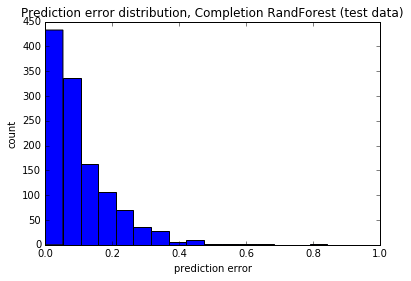

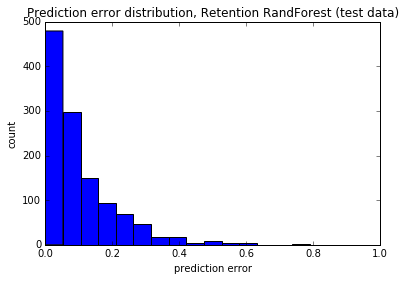

In [177]:
hist_plot_delta(RF_model, X_test, y_test, model_name='RandForest (test data)')
# hist_plot_delta(RF_model, X_train, y_train, model_name='RandForest (train data)')

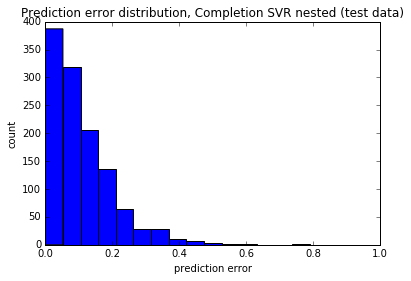

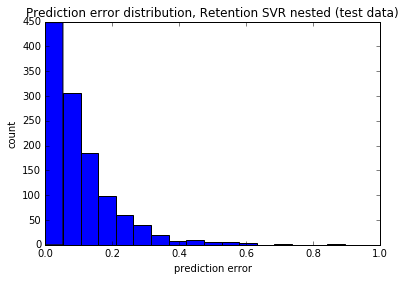

In [178]:
hist_plot_delta(SVR_nested, X_test, y_test, model_name='SVR nested (test data)', nested=True)
# hist_plot_delta(SVR_nested, X_train, y_train, model_name='SVR nested (train data)')

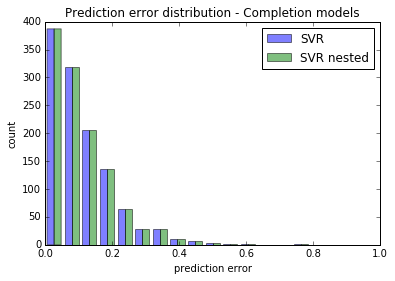

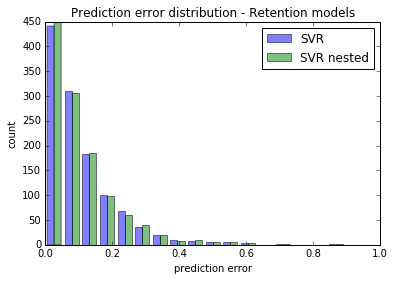

In [186]:
def compare_hist_plot_delta(m1, m2, X, y, model_names=None, nested=[False, False]):
    bucket = np.linspace(0, 1, 20)
    y1, y2 = y[:,0], y[:,1]
    
    y1_predicted, y2_predicted = {}, {}
    y1_predicted['m1'] = m1['reg1'].predict(X)
    y1_predicted['m2'] = m2['reg1'].predict(X)
    if nested[0]:
        X_tmp = np.concatenate((X, reshape_y(y1_predicted['m1'])), axis=1)
        y2_predicted['m1'] = m1['reg2'].predict(X_tmp)
    else:
        y2_predicted['m1'] = m1['reg2'].predict(X)
    if nested[1]:
        X_tmp = np.concatenate((X, reshape_y(y1_predicted['m2'])), axis=1)
        y2_predicted['m2'] = m2['reg2'].predict(X_tmp)
    else:
        y2_predicted['m2'] = m2['reg2'].predict(X)
        
    delta1 = { 'm1': abs(y1 - y1_predicted['m1']),
               'm2': abs(y1 - y1_predicted['m2'])}
    delta2 = { 'm1': abs(y2 - y2_predicted['m1']),
               'm2': abs(y2 - y2_predicted['m2'])}
    
    plt.title('Prediction error distribution - Completion models')
    plt.xlabel('prediction error')
    plt.ylabel('count')
    plt.hist([delta1['m1'], delta1['m2']], bucket, alpha=0.5)
    plt.legend(model_names)
    plt.show()
    
    plt.title('Prediction error distribution - Retention models')
    plt.xlabel('prediction error')
    plt.ylabel('count')
    plt.hist([delta2['m1'], delta2['m2']], bucket, alpha=0.5)
    plt.legend(model_names)
    plt.show()

compare_hist_plot_delta(SVR_model, SVR_nested, X_test, y_test, ['SVR', 'SVR nested'], nested=[False, True])

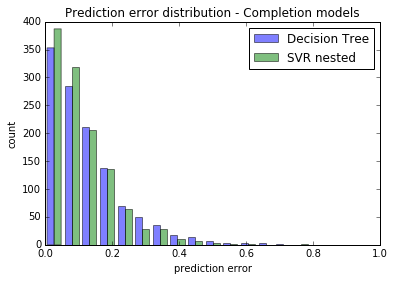

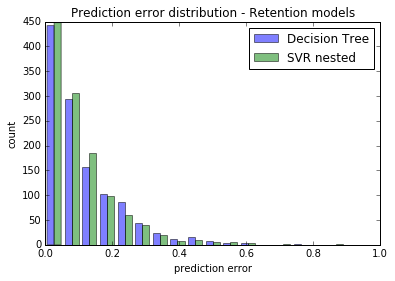

In [187]:
compare_hist_plot_delta(DT_model, SVR_nested, X_test, y_test, ['Decision Tree', 'SVR nested'], nested=[False, True])